In [1]:
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import visdcc

from jupyter_dash import JupyterDash
from dash import dcc, html, Dash
from dash.dependencies import Input, Output

plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')

/Users/kevin/.conda/envs/hihi/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/kevin/.conda/envs/hihi/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
df = pd.DataFrame({
    'order': [1, 2, 3, 4, 5],
    'item': [['🍎', '🥚', '🥛'], ['🥕', '🥛'], ['🍎', '🥚', '🥕'], ['🍎', '🥚'], ['🍎', '🥕']]
})
df

,order,item
0,1,"[🍎, 🥚, 🥛]"
1,2,"[🥕, 🥛]"
2,3,"[🍎, 🥚, 🥕]"
3,4,"[🍎, 🥚]"
4,5,"[🍎, 🥕]"


In [3]:
te = TransactionEncoder()
te_data = te.fit_transform(df['item'].values, sparse=True)
df_te = pd.DataFrame.sparse.from_spmatrix(te_data, columns=te.columns_)
print(f'No. Transactions: {df_te.shape[0]:,.0f}')

No. Transactions: 5


In [4]:
df_te

,🍎,🥕,🥚,🥛
0,1,0,1,1
1,0,1,0,1
2,1,1,1,0
3,1,0,1,0
4,1,1,0,0


In [5]:
support_dist = df_te.sum(axis=0).sort_values(ascending=False).reset_index()
support_dist.columns = ['item', 'amount']
support_dist['support'] = support_dist['amount'] / df_te.shape[0]
support_dist.describe(percentiles=[.25, .5, .75, .95, .99])

,amount,support
count,4.000000,4.000000
mean,3.000000,0.600000
std,0.816497,0.163299
min,2.000000,0.400000
25%,2.750000,0.550000
50%,3.000000,0.600000
75%,3.250000,0.650000
95%,3.850000,0.770000
99%,3.970000,0.794000
max,4.000000,0.800000


In [6]:
support_dist

,item,amount,support
0,🍎,4,0.8
1,🥕,3,0.6
2,🥚,3,0.6
3,🥛,2,0.4


In [7]:
fp_frequent_itemsets = fpgrowth(df_te, min_support=0.5, use_colnames=True)
fp_rules = association_rules(fp_frequent_itemsets, metric="confidence", min_threshold=0.3)
print(f'No. Rules: {fp_rules.shape[0]}')
fp_rules

No. Rules: 2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(🥚),(🍎),0.6,0.8,0.6,1.00,1.25,0.12,inf
1,(🍎),(🥚),0.8,0.6,0.6,0.75,1.25,0.12,1.6


In [8]:
support_ranges_ = np.arange(0.1, 0.7, 0.1)
confidence_ranges_ = np.arange(0.3, 0.8, 0.1)

report = pd.DataFrame(columns=['support_level', 'confidence_level', 'no_rules'])
for s in support_ranges_:
    for c in tqdm(confidence_ranges_, desc=f'Support Threshold: {s:,.5f}'):
        frequent_itemsets = fpgrowth(df_te, min_support=s, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=c)
        tmp = pd.DataFrame({'support_level': [f'support level: {s:,.5f}'], 'confidence_level': [c], 'no_rules': [rules.shape[0]]})
        report = pd.concat([report, tmp])

Support Threshold: 0.60000: 100%|████████████████| 5/5 [00:00<00:00, 136.90it/s]


<AxesSubplot:xlabel='confidence_level', ylabel='no_rules'>

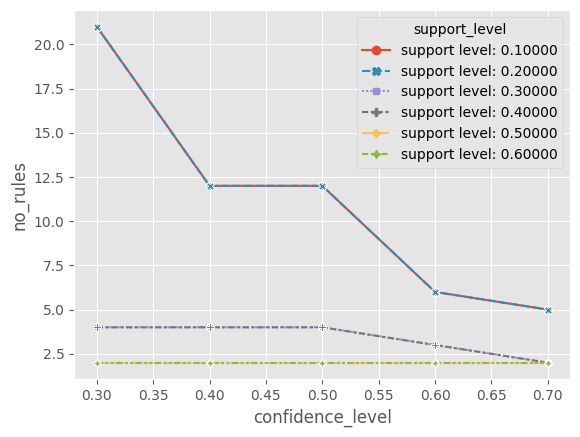

In [9]:
sns.lineplot(data=report.reset_index(drop=True), x='confidence_level', y='no_rules',
             hue='support_level', style='support_level', markers=True)

In [10]:
frequent_itemsets = fpgrowth(df_te, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(f'No. Rules: {rules.shape[0]}')

No. Rules: 21


In [11]:
for i in ['antecedents', 'consequents']:
    rules[f'combo_{i}'] = rules[i].map(lambda x: len(x))
    rules[i] = rules[i].map(lambda x: ' + '.join(tuple(x)))
rules['combo'] = rules['combo_antecedents'].astype(str) + ' - ' + rules['combo_consequents'].astype(str)
rules.drop(columns=['combo_antecedents', 'combo_consequents'], inplace=True)

In [12]:
rules['combo'].value_counts()

1 - 1    11
2 - 1     6
1 - 2     4
Name: combo, dtype: int64

In [13]:
rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,combo
0,🥚,🍎,0.6,0.8,0.6,1.000000,1.250000,0.12,inf,1 - 1
7,🥚 + 🥛,🍎,0.2,0.8,0.2,1.000000,1.250000,0.04,inf,2 - 1
9,🥛 + 🍎,🥚,0.2,0.6,0.2,1.000000,1.666667,0.08,inf,2 - 1
16,🥚 + 🥕,🍎,0.2,0.8,0.2,1.000000,1.250000,0.04,inf,2 - 1
1,🍎,🥚,0.8,0.6,0.6,0.750000,1.250000,0.12,1.6,1 - 1
12,🥕,🍎,0.6,0.8,0.4,0.666667,0.833333,-0.08,0.6,1 - 1
3,🥛,🥚,0.4,0.6,0.2,0.500000,0.833333,-0.04,0.8,1 - 1
4,🥛,🍎,0.4,0.8,0.2,0.500000,0.625000,-0.12,0.4,1 - 1
18,🥕 + 🍎,🥚,0.4,0.6,0.2,0.500000,0.833333,-0.04,0.8,2 - 1
6,🥛,🥕,0.4,0.6,0.2,0.500000,0.833333,-0.04,0.8,1 - 1


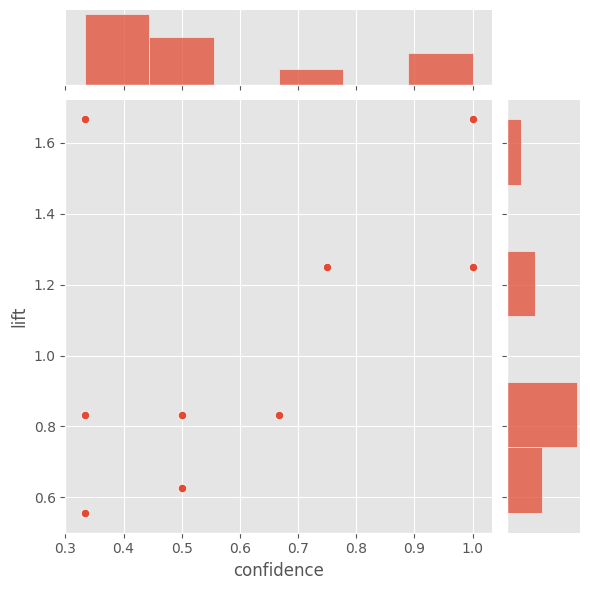

In [14]:
sns.jointplot(data=rules.query('lift < 200'), x='confidence', y='lift')
# plt.savefig('media/fig4_correlation.png')

In [15]:
node_list = list(set(rules['antecedents'].unique().tolist() + rules['consequents'].unique().tolist()))
nodes = [{'id': node_name, 'label': node_name, 'shape': 'dot', 'size': 7} for i, node_name in enumerate(node_list)]
edges = []
for row in rules.to_dict(orient='records'):
    source, target = row['antecedents'], row['consequents']
    edges.append({
        'id': source + "__" + target,
        'from': source,
        'to': target,
        'width': row['lift'],
    })

In [17]:
app = JupyterDash(__name__)
app.layout = html.Div([
    visdcc.Network(id='net', data={'nodes': nodes, 'edges': edges}, options=dict(height='1000px', width='100%')),
    dcc.RadioItems(id='color', value='Red')
])

app.run_server(mode='inline')

/Users/kevin/.conda/envs/hihi/lib/python3.10/site-packages/jupyter_dash/jupyter_app.py:310: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  thread.setDaemon(True)
